In [ ]:
#!/usr/bin/env python
# coding: utf-8

## Lendo os dados e Configurações do Matplotlib<br>


In[11]:

Importações e configurações

In [1]:
import zipfile
import os

# Suponha que você subiu "alphasense_b_sensors.zip"
with zipfile.ZipFile("alphasense_b_sensors.zip", "r") as zip_ref:
    zip_ref.extractall("alphasense_b_sensors")

# Verificar arquivos
os.listdir("alphasense_b_sensors")

['alphasense_b_sensors']

In [6]:
#!wget https://media.githubusercontent.com/media/pedromujica1/aqm-dataset/refs/heads/main/datasets-grafana/envcity_plot_lib.py -O envcity_plot_lib.py -q -O /dev/null
#!wget https://raw.githubusercontent.com/pedromujica1/aqm-dataset/refs/heads/main/datasets-grafana/best-co.csv -o best-co.csv -q -O /dev/null
#!wget https://raw.githubusercontent.com/pedromujica1/aqm-dataset/refs/heads/main/datasets-grafana/co_ae.csv -o co_ae.csv -q -O /dev/null
#!wget https://raw.githubusercontent.com/pedromujica1/aqm-dataset/refs/heads/main/datasets-grafana/co_we.csv -o co_we.csv -q -O /dev/null
#!wget https://raw.githubusercontent.com/pedromujica1/aqm-dataset/refs/heads/main/datasets-grafana/temperatura.csv -o temperatura.csv -q -O /dev/null
#!wget https://raw.githubusercontent.com/pedromujica1/aqm-dataset/refs/heads/main/datasets-grafana/envcity_plot_lib.py -O envcity_plot_lib.py -q -O /dev/null

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from envcity_plot_lib import *
from alphasense_b_sensors.alphasense_b_sensors.alphasense_sensors import *
from itertools import product

configurações do Matplotlib

In [40]:
#configurações do matplotlib
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": "Times",
    "font.size" : 10,
})
#Versões das bibliotecas

print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)

Numpy version:  2.0.2
Pandas version:  2.2.2


In[12]:

!wget https://media.githubusercontent.com/media/MateusMaruzka/aqm-dataset/main/envcity_aqm_df.csv -O aqm.csv

In[13]:

In [ ]:
#!wget https://raw.githubusercontent.com/MateusMaruzka/aqm_envcity_sw/main/alphasense_sensors.py -O alphasense_sensors.py
#!wget https://raw.githubusercontent.com/MateusMaruzka/aqm_envcity_sw/main/dados_correcao_temp.py -O dados_correcao_temp.py
#!wget https://raw.githubusercontent.com/MateusMaruzka/aqm_envcity_sw/main/dados_alphasense.py -O dados_alphasense.py

## Organizando o dataset

In[14]:

Leitura do dataset

In [41]:
aqm = pd.read_csv('envcity_aqm_df.csv')
print(aqm.shape)
print(aqm.describe())

(194485, 181)
            e1_anem  e1_anem_volt         e1_co       e1_co_2       e1_co_3  \
count  43464.000000  25641.000000  43464.000000  43464.000000  43464.000000   
mean       8.784224      0.501088   -257.343391    232.316820    186.055181   
std        2.550723      0.018040   1619.857223    900.151430    886.591724   
min        0.000000      0.000000 -25741.396484 -15297.602539 -15306.832031   
25%        8.342664      0.498188   -285.960434    110.959763     46.315489   
50%        8.472690      0.503438    232.782364    187.673752    118.113029   
75%       10.501109      0.507937    332.472198    293.837364    227.100555   
max       36.000000      0.619500  14709.538086  13169.983398  13040.117188   

            e1_co_4      e1_co_ae      e1_co_we  e1_location        e1_no2  \
count  43464.000000  25641.000000  25641.000000          0.0  43464.000000   
mean    -393.044602      0.308851      0.462073          NaN     40.933911   
std      891.801038      0.069943      0

impeza de colunas não utilizadas

In [42]:
for label, p, s in product(['anem'], ['e1_', 'e2_', 'e2sp_'], ['_volt', '']):
    print(p + label+s)
    try:
        aqm.drop(labels = p + label + s, axis = 1,inplace=True)
    except:
        print('err')
# aqm.set_index('time', inplace=True)

e1_anem_volt
e1_anem
e2_anem_volt
e2_anem
e2sp_anem_volt
e2sp_anem


In[34]:

In [43]:
aqm_filtered = aqm.copy()

Remoção de linhas com valores inválidos

In [44]:
%%time
for index, row in aqm.iterrows():
    if (row == -3).sum() > 0:
        aqm_filtered.drop(index, inplace=True)

CPU times: user 2min 1s, sys: 44.5 s, total: 2min 45s
Wall time: 2min 38s


aqm_filtered.reset_index(drop=True)

In [45]:
aqm_filtered.set_index('time', inplace=True)
aqm = aqm_filtered

In [46]:
print(aqm.shape)
#%%
# ## Filtro por limites físicos dos sensores
labels =  ['co', 'so2', 'ox', 'no2']
prefix = ['e1_', 'e2_', 'e2sp_']
suffix = ['_ae', '_we']

(193809, 174)


In [47]:
for label, p, s in product(labels, prefix, suffix):
  data = aqm[p+label+s]
  idx = (data > 6.14) | (data < 0.05)
  data.loc[idx] = np.nan

In [48]:
for p in prefix:
  data = aqm[p + 'temp']
  idx = (data > 50) | (data <= 1)
  data.loc[idx] = np.nan

#%%
# ## Verificando colunas faltantes
print(aqm.shape)
# In[37]:

(193809, 174)


aqm.describe()

## Métricas de Avaliação<br>
<br>
* Métricas de avaliação [https://amt.copernicus.org/articles/11/291/2018/amt-11-291-2018.pdf]<br>
1. $R^2$<br>
<br>
2. **Pearson r**<br>
<br>
3. $\mathrm{RMSE} = \sqrt{\frac{\sum_{i=1}^{N}(y_{ref} - \hat{y})^{2})}{N}}$<br>
<br>
4. $\mathrm{CvMAE} = \frac{\overbrace{MAE}^{\textrm{Mean absolute error}}}{\mu_{ref}} = \frac{1}{\mu_{ref}} \frac{\sum_{i=1}^{N}{|y_{ref} - \hat{y}}|}{N}$<br>


In[38]:

In [49]:
def pearson_r(y, yref):
    my = np.mean(y)
    myref = np.mean(yref)
    _y = y - my
    _yref = yref - myref
    num = np.sum(np.dot(_y, _yref))
    den = np.sum(_y**2) * np.sum(_yref**2)
    den = np.sqrt(den)
    return num/den
def mse(y, yref):
    return np.mean(np.square(np.subtract(yref, y)))

def rmse(y, yref):
    return np.sqrt(mse(y, yref))

def mae(y, yref):
    return np.mean(np.abs(np.subtract(yref, y)))

def cvmae(y, yref):
    yref_mean = np.mean(yref)
    return mae(y, yref) / yref_mean

def exploratory_analysis(dict_data_e1, dict_data_e2, labels, latex_labels, start, end):
    table_exploratory_analysis = {}
    for idx, l in enumerate(labels):
        e1 = dict_data_e1[l]
        e2 = dict_data_e2[l]
        concatenated = pd.concat([e1, e2], axis=1, keys=['Station 1', 'Station 2'])
        table_exploratory_analysis[l] = describe(concatenated, ['median'], ['25%', '50%', '75%'])
    return table_exploratory_analysis

### Funções Gráficos<br>
<br>
**plot_data_by_time_and_regr_plot** gera dois gráficos, um do lado do outro. O primeiro é os dados em função do tempo e o segundo é um gráfico de dispersão entre os dois sensores

In[40]:

### Análise

#### Resultados complementas:<br>
1. Comunicação degrada a partir de 30 graus<br>
2. Pode estar relacionada ao CI SX1276<br>
<br>
Ações:<br>
Dropar toda as linhas com erro

In[41]:

atex_labels it is only for printing<br>
latex_labels = ['CO', 'NO_2', 'O_X', 'SO_2', 'PM1.0', 'PM2.5', 'PM10']

for label in labels:<br>
  for p in preffix:<br>
    plt.figure()

In [24]:

#     data_filtered = aqm[p+label]

#     data_temp = aqm[p+'temp']

#     data_filtered = data_filtered.dropna()
#     data_temp = data_temp.dropna()

#     teste = pd.concat([data_filtered, data_temp], axis =1)

#     plt.gca().scatter(y = teste[p+label], x=teste[p+'temp'], marker = '.')
#     plt.gca().set_xlabel('Temperatura')
#     plt.gca().set_ylabel('Tensão')
#     plt.title(label)

    plt.show()<br>
    print(aqm[p+label].min(), aqm[p+label].max())<br>
%<br>
## Checando ausência de umidade relativa

In [50]:
pin_ur = aqm['pin_umid'].isna().sum()
print(pin_ur)

41828


%<br>
['2023-03-18 10:00:00':'2023-03-22 10:00:00'].

## Plot dos dados brutos: sensor vs. umidade relativa

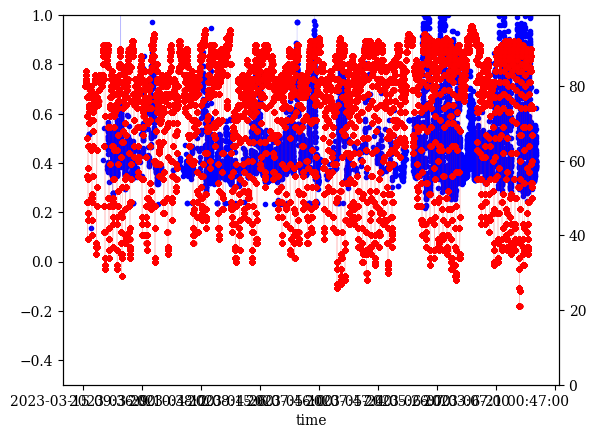

In [51]:
plt.figure()
aqm['e2sp_co_we'].plot(marker = '.', linewidth = 0.1, color = 'b')
plt.gca().set_ylim([-0.5, 1])
ax = plt.gca().twinx()
aqm['pin_umid'].plot(marker = '.', linewidth = 0.1, ax = ax, color = 'r')
ax.set_ylim([0, 99])
# plt.gcf().autofmt_xdate()
plt.show()

%<br>
mportação de modelos e métricas do scikit-learn

In [114]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KernelCenterer,Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,\
                                    validation_curve, cross_val_score, \
                                    cross_validate, \
                                    RepeatedKFold, cross_val_predict, StratifiedKFold
from sys import version

%

In [53]:
 ## Preparo do dataset para regressão
labels =  ['co_we', 'co_ae']
preffix = ['e2sp_']
label_ref= 'iag_co'

In [54]:
df = aqm

In [55]:
df = aqm[[preffix[0] + labels[0], preffix[0] + labels[1], 'pin_umid', label_ref]]
df

,e2sp_co_we,e2sp_co_ae,pin_umid,iag_co
time,,,,
2023-02-15 13:41:00,NaN,NaN,NaN,NaN
2023-02-15 13:42:00,NaN,NaN,NaN,NaN
2023-02-15 13:43:00,NaN,NaN,NaN,NaN
2023-02-15 13:44:00,NaN,NaN,NaN,NaN
2023-02-15 13:45:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2023-06-30 15:01:00,NaN,NaN,NaN,NaN
2023-06-30 15:02:00,NaN,NaN,NaN,NaN
2023-06-30 15:03:00,NaN,NaN,NaN,NaN


In [56]:
df.index = pd.to_datetime(df.index)
df = df.resample('15min').mean()
# df = df.interpolate(method = 'time', limit=5)
df = df.dropna()
#
print(df.shape)
df
#%%

(3606, 4)


,e2sp_co_we,e2sp_co_ae,pin_umid,iag_co
time,,,,
2023-03-16 21:00:00,0.517687,0.527812,75.0,1.405933
2023-03-16 21:15:00,0.517687,0.527812,75.0,1.410133
2023-03-19 15:15:00,3.000000,4.000000,83.0,1.340000
2023-03-20 05:00:00,0.411938,0.287250,90.0,1.412533
2023-03-20 06:45:00,0.540187,0.288375,91.0,1.485333
...,...,...,...,...
2023-06-23 10:45:00,0.574346,0.256217,55.0,2.296733
2023-06-23 11:00:00,0.505305,0.253775,47.0,2.178067
2023-06-23 11:15:00,0.449196,0.231416,47.0,2.085533


## Cálculo da concentração em ppm com coeficientes da Alphasense

In [57]:
co = Alphasense_Sensors("CO-B4", "162741354")
no2 = Alphasense_Sensors("NO2-B43F", "202742056")
so2 = Alphasense_Sensors("SO2-B4", "164240348")
ox = Alphasense_Sensors("OX-B431", "204240461")

to mV

In [58]:
we = df[preffix[0] + labels[0]]*1000
ae = df[preffix[0] + labels[1]]*1000
# temp = df[preffix[0] + 'temp']
# ppb, _ , _ , _ = co.all_algorithms(we, ae, temp.to_numpy())
we

,e2sp_co_we
time,
2023-03-16 21:00:00,517.687500
2023-03-16 21:15:00,517.687500
2023-03-19 15:15:00,3000.000000
2023-03-20 05:00:00,411.937505
2023-03-20 06:45:00,540.187478
...,...
2023-06-23 10:45:00,574.345976
2023-06-23 11:00:00,505.304635
2023-06-23 11:15:00,449.196428


In [59]:
ppb = ((we - co.electronic_we) - (ae - co.electronic_ae))/co.sensitivity

In [60]:
df[preffix[0] + 'co'] = ppb / 1000
df[preffix[0] + 'co']
df


,e2sp_co_we,e2sp_co_ae,pin_umid,iag_co,e2sp_co
time,,,,,
2023-03-16 21:00:00,0.517687,0.527812,75.0,1.405933,-0.061581
2023-03-16 21:15:00,0.517687,0.527812,75.0,1.410133,-0.061581
2023-03-19 15:15:00,3.000000,4.000000,83.0,1.340000,-2.487745
2023-03-20 05:00:00,0.411938,0.287250,90.0,1.412533,0.268842
2023-03-20 06:45:00,0.540187,0.288375,91.0,1.485333,0.580423
...,...,...,...,...,...
2023-06-23 10:45:00,0.574346,0.256217,55.0,2.296733,0.742963
2023-06-23 11:00:00,0.505305,0.253775,47.0,2.178067,0.579730
2023-06-23 11:15:00,0.449196,0.231416,47.0,2.085533,0.497010


plt.plot(ppb)<br>
print(df.iloc[0])<br>
print(co.all_algorithms(0.46, 0.3, np.array(29.2)))

%<br>
## Preparação de features (X) e target (Y)

In [61]:
Yco = df[label_ref]
Yco

,iag_co
time,
2023-03-16 21:00:00,1.405933
2023-03-16 21:15:00,1.410133
2023-03-19 15:15:00,1.340000
2023-03-20 05:00:00,1.412533
2023-03-20 06:45:00,1.485333
...,...
2023-06-23 10:45:00,2.296733
2023-06-23 11:00:00,2.178067
2023-06-23 11:15:00,2.085533


In [62]:
Xco = df.loc[Yco.index][[preffix[0] + 'co', preffix[0] + 'co_we',preffix[0] + 'co_ae', 'pin_umid']]
Xco

,e2sp_co,e2sp_co_we,e2sp_co_ae,pin_umid
time,,,,
2023-03-16 21:00:00,-0.061581,0.517687,0.527812,75.0
2023-03-16 21:15:00,-0.061581,0.517687,0.527812,75.0
2023-03-19 15:15:00,-2.487745,3.000000,4.000000,83.0
2023-03-20 05:00:00,0.268842,0.411938,0.287250,90.0
2023-03-20 06:45:00,0.580423,0.540187,0.288375,91.0
...,...,...,...,...
2023-06-23 10:45:00,0.742963,0.574346,0.256217,55.0
2023-06-23 11:00:00,0.579730,0.505305,0.253775,47.0
2023-06-23 11:15:00,0.497010,0.449196,0.231416,47.0


### TREINAMENTO COM DADOS DA ESTAÇÃO GRAFANA

In [117]:
def pearson_r(y, yref):
    my = np.mean(y)
    myref = np.mean(yref)
    _y = y - my
    _yref = yref - myref
    num = np.sum(np.dot(_y, _yref))
    den = np.sum(_y**2) * np.sum(_yref**2)
    den = np.sqrt(den)
    return num/den
def mse(y, yref):
    return np.mean(np.square(np.subtract(yref, y)))

def rmse(y, yref):
    return np.sqrt(mse(y, yref))

def mae(y, yref):
    return np.mean(np.abs(np.subtract(yref, y)))

def cvmae(y, yref):
    yref_mean = np.mean(yref)
    return mae(y, yref) / yref_mean

def exploratory_analysis(dict_data_e1, dict_data_e2, labels, latex_labels, start, end):
    table_exploratory_analysis = {}
    for idx, l in enumerate(labels):
        e1 = dict_data_e1[l]
        e2 = dict_data_e2[l]
        concatenated = pd.concat([e1, e2], axis=1, keys=['Station 1', 'Station 2'])
        table_exploratory_analysis[l] = describe(concatenated, ['median'], ['25%', '50%', '75%'])
    return table_exploratory_analysis

In [119]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from envcity_plot_lib import *
from itertools import product


#Leitura da base de dados da estação grafana com os dados de CO
df_ae = pd.read_csv("co_ae.csv")
df_we = pd.read_csv("co_we.csv")
df_temp = pd.read_csv("temperatura.csv") #df da temperatura
df_bestCO = pd.read_csv('best-co.csv')

df_temp.columns = ['time', 'temperatura']
df_bestCO['time'] = pd.to_datetime(df_bestCO['time'], unit='ms')

# #padronizando time nas tabelas
df_bestCO['time'] = pd.to_datetime(df_bestCO['time'], unit='ms').dt.round('1s')
df_ae['time'] = pd.to_datetime(df_ae['time']).dt.round('1s')
df_we['time'] = pd.to_datetime(df_we['time']).dt.round('1s')
df_temp['time'] = pd.to_datetime(df_temp['time']).dt.round('1s')

# #Limpeza das colunas de AE e WE (remover " ppb" e converter para float)
df_ae['CO_AE'] = df_ae['CO_AE'].str.replace(' ppb', '', regex=False).astype(float)
df_we['CO_WE'] = df_we['CO_WE'].str.replace(' ppb', '', regex=False).astype(float)
df_temp['temperatura'] = df_temp['temperatura'].str.replace(' °C', '', regex=False) #eliminando strings

# #Mesclagem com base na coluna 'time'
df = df_bestCO.merge(df_ae, on='time', how='inner') \
              .merge(df_we, on='time', how='inner') \
              .merge(df_temp, on='time', how='inner')

df = df.dropna()
df


,time,CO,CO_AE,CO_WE,temperatura
0,2025-03-07 13:22:32,929.284785,0.533,0.520,29.2
1,2025-03-07 13:23:38,929.298999,0.531,0.520,29.2
2,2025-03-07 13:26:57,929.331408,0.527,0.524,29.3
3,2025-03-07 13:30:16,929.242062,0.540,0.517,29.4
4,2025-03-07 13:33:35,929.162088,0.549,0.505,29.4
...,...,...,...,...,...
144218,2025-06-16 19:43:31,1829.584450,0.546,0.538,23.9
144219,2025-06-16 19:43:31,1829.584450,0.546,0.538,23.9
144220,2025-06-16 19:43:31,1829.584450,0.546,0.538,23.9
144221,2025-06-16 19:43:31,1829.584450,0.546,0.538,23.9


In [120]:
#tratando df principal
aqm = pd.read_csv('envcity_aqm_df.csv')


for label, p, s in product(['anem'], ['e1_', 'e2_', 'e2sp_'], ['_volt', '']):
    print(p + label+s)
    try:
        aqm.drop(labels = p + label + s, axis = 1,inplace=True)
    except:
        print('err')


aqm_filtered = aqm.copy()

for index, row in aqm.iterrows():
    if (row == -3).sum() > 0:
        aqm_filtered.drop(index, inplace=True)



aqm_filtered.set_index('time', inplace=True)
aqm = aqm_filtered

labels =  ['co', 'so2', 'ox', 'no2']
prefix = ['e1_', 'e2_', 'e2sp_']
suffix = ['_ae', '_we']



for label, p, s in product(labels, prefix, suffix):
  data = aqm[p+label+s]
  idx = (data > 6.14) | (data < 0.05)
  data.loc[idx] = np.nan

for p in prefix:
  data = aqm[p + 'temp']
  idx = (data > 50) | (data <= 1)
  data.loc[idx] = np.nan

#%%
# ## Verificando colunas faltantes
print(aqm.shape)


e1_anem_volt
e1_anem
e2_anem_volt
e2_anem
e2sp_anem_volt
e2sp_anem
(193809, 174)


In [121]:
print(aqm.columns.tolist())

['e1_co', 'e1_co_2', 'e1_co_3', 'e1_co_4', 'e1_co_ae', 'e1_co_we', 'e1_location', 'e1_no2', 'e1_no2_2', 'e1_no2_3', 'e1_no2_4', 'e1_no2_ae', 'e1_no2_we', 'e1_ox', 'e1_ox_2', 'e1_ox_3', 'e1_ox_4', 'e1_ox_ae', 'e1_ox_we', 'e1_pm10', 'e1_pm1_0', 'e1_pm2_5', 'e1_rssi', 'e1_snr', 'e1_so2', 'e1_so2_2', 'e1_so2_3', 'e1_so2_4', 'e1_so2_ae', 'e1_so2_we', 'e1_temp', 'e1_umid', 'e2_application_id', 'e2_co', 'e2_co_2', 'e2_co_3', 'e2_co_4', 'e2_co_ae', 'e2_co_we', 'e2_device_id', 'e2_eu', 'e2_fcnt', 'e2_field1', 'e2_field2', 'e2_field3', 'e2_field4', 'e2_field5', 'e2_field6', 'e2_field7', 'e2_field8', 'e2_fport', 'e2_frequency', 'e2_frm_payload', 'e2_gateway_eui', 'e2_gateway_location', 'e2_lora_bandwidth', 'e2_lora_coding_rate', 'e2_lora_spreading_factor', 'e2_no2', 'e2_no2_2', 'e2_no2_3', 'e2_no2_4', 'e2_no2_ae', 'e2_no2_we', 'e2_ox', 'e2_ox_2', 'e2_ox_3', 'e2_ox_4', 'e2_ox_ae', 'e2_ox_we', 'e2_payload', 'e2_pm10', 'e2_pm1_0', 'e2_pm2_5', 'e2_rssi', 'e2_snr', 'e2_so2', 'e2_so2_2', 'e2_so2_3', 'e

In [122]:
#fazendo filtragem do IAG


#filtrando as linhas onde e1_co tem valores válidos
df_filtrado = aqm[aqm['e1_co'].notna()][['e1_co', 'iag_co']]

#remover linhas onde iag_co é NaN
df_filtradoIAG = df_filtrado[df_filtrado['iag_co'].notna()]

df_filtradoIAG

,e1_co,iag_co
time,,
2023-03-16 00:00:00,374.827820,1.378
2023-03-16 00:04:00,383.092285,1.400
2023-03-16 00:08:00,391.873291,1.420
2023-03-16 00:12:00,366.046844,1.370
2023-03-16 00:15:00,374.311310,1.363
...,...,...
2023-05-19 19:36:00,672.864990,1.726
2023-05-19 19:40:00,701.274170,1.695
2023-05-19 19:44:00,771.005676,1.722


In [123]:
df= df.iloc[:len(df_filtradoIAG)].copy() #iloc garante mesmo número de linhas para evitar erro.
# Adiciona a coluna 'iag_co' ao DataFrame 'df', usando os dados da coluna 'iag_co' de 'df_filtradoIAG'

df['iag_co'] = df_filtradoIAG['iag_co'].reset_index(drop=True) # evita que o índice antigo seja mantido, o que quebraria a correspondência entre as linhas dos DataFrames.

df=df.dropna()
df_iag_co = df[['iag_co']].copy()
df = df.drop(columns=["time", "iag_co"])




In [124]:
#Preparo do dataset para regressão
labelsGrafana =  ['CO_AE', 'CO_WE']
label_refGrafana= 'iag_co'
YcoGrafana = df_iag_co # Y do IAG

XcoGrafana = df.loc[YcoGrafana.index][['CO','CO_WE', 'CO_AE', 'temperatura']] # X da estação grafana


#Usando subset para evitar CRASSHHHH
XcoGrafana_small = XcoGrafana.sample(n=4000, random_state=42)
YcoGrafana_small = YcoGrafana.loc[XcoGrafana_small.index]

dfX_sorted = XcoGrafana.copy()
dfX_sorted["iag_co"] = YcoGrafana.values  # temporarily combine

dfX_sorted = dfX_sorted.sort_values("iag_co")

# Take evenly spread samples
step = len(dfX_sorted) // 4000
df_sampled = dfX_sorted.iloc[::step].copy()

# Final X and Y
XcoGrafana_small = df_sampled.drop(columns=["iag_co"])
YcoGrafana_small = df_sampled[["iag_co"]]
XcoGrafana




,CO,CO_WE,CO_AE,temperatura
0,929.284785,0.520,0.533,29.2
1,929.298999,0.520,0.531,29.2
2,929.331408,0.524,0.527,29.3
3,929.242062,0.517,0.540,29.4
4,929.162088,0.505,0.549,29.4
...,...,...,...,...
22148,1829.703691,0.542,0.532,24.4
22149,1829.703691,0.542,0.532,24.4
22150,1829.703691,0.542,0.532,24.4
22151,1829.703691,0.542,0.532,24.4


In [94]:
import plotly.graph_objects as go

fig = go.Figure()

for column in XcoGrafana.columns:
    fig.add_trace(go.Scatter(
        x=XcoGrafana.index,
        y=XcoGrafana[column],
        mode='lines',
        name=column
    ))

fig.update_layout(
    title="Sensor Data from XcoGrafana",
    xaxis_title="Index",
    yaxis_title="Value",
    legend_title="Features",
    height=600
)

fig.show()


Split dos dados

In [126]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KernelCenterer,Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,\
                                    validation_curve, cross_val_score, \
                                    cross_validate, \
                                    RepeatedKFold, cross_val_predict, StratifiedKFold
from sys import version



X_train, X_valid, y_train, y_valid = train_test_split(XcoGrafana_small, YcoGrafana_small, train_size=0.8)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)

Validação cruzada repetida

In [127]:
kfold = RepeatedKFold(n_splits = 5, n_repeats = 1)
# kfold = StratifiedKFold(n_splits = 5)

X_treino,x-teste,x-valido estação matheus
(2163, 4)
(721, 4)
(722, 4)
mesmos parametros grafana
(13289, 3)
(4430, 3)
(4430, 3)



In [128]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(2658, 4)
(886, 4)
(887, 4)


%

param_grid = {"randomforestregressor__n_estimators": [15, 50],<br>
              "randomforestregressor__max_depth": [64, 512, 1024],<br>
              # "randomforestregressor__oob_score" : [True],<br>
              # "randomforestregressor__bootstrap" : [True],<br>
              'randomforestregressor__max_features': ["sqrt", "log2", 0.3, 0.1],<br>
              'randomforestregressor__criterion': ['squared_error']}

## Otimização de hiperparâmetros (Random Forest)

param_grid = {"randomforestregressor__n_estimators": randint(1, 512),<br>
              "randomforestregressor__max_depth": randint(1, 512),<br>
              #  "randomforestregressor__oob_score" : [True],<br>
              "randomforestregressor__bootstrap" : [False, True],<br>
              'randomforestregressor__max_features': ["sqrt", "log2", None],<br>
              'randomforestregressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse']}<br>
#

np.geomspace(2, 1024, 10)

In [129]:
param_grid = {"randomforestregressor__n_estimators": np.array([32, 128, 512, 1024]),
              # "randomforestregressor__max_depth": None,
              #  "randomforestregressor__oob_score" : [True],
              # "randomforestregressor__bootstrap" : [False, True],
              # 'randomforestregressor__max_features': ["sqrt", "log2", None],
              'randomforestregressor__criterion': ['squared_error' ]}# 'absolute_error', 'friedman_mse']}

Pipeline com RandomForest

In [130]:
%%time
regressor = make_pipeline(RandomForestRegressor())

linReg = LinearRegression().fit(X_train, y_train)


gs = GridSearchCV(regressor, param_grid=param_grid, n_jobs=-1, verbose = 3,\
                  return_train_score=True, cv = kfold, error_score = 'raise')


res = gs.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



CPU times: user 20.2 s, sys: 343 ms, total: 20.6 s
Wall time: 1min 29s


GridSearch com validação cruzada

In [131]:
%%time
gs = GridSearchCV(regressor, param_grid=param_grid, n_jobs=-1, verbose = 3,\
                  return_train_score=True, cv = kfold, error_score = 'raise')

res = gs.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



CPU times: user 31.1 s, sys: 442 ms, total: 31.5 s
Wall time: 1min 34s


%% Resultado da otimização

In [132]:
print(train_data := pd.DataFrame(res.cv_results_))

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.442825      0.009335         0.020835        0.002828   
1       2.000642      0.297936         0.075317        0.025386   
2       8.787787      0.687217         0.240583        0.063348   
3      17.039105      2.224156         0.584177        0.321439   

  param_randomforestregressor__criterion  \
0                          squared_error   
1                          squared_error   
2                          squared_error   
3                          squared_error   

   param_randomforestregressor__n_estimators  \
0                                         32   
1                                        128   
2                                        512   
3                                       1024   

                                              params  split0_test_score  \
0  {'randomforestregressor__criterion': 'squared_...          -0.803281   
1  {'randomforestregressor__criterion': 'squared_...

In [133]:
with open('tabela_treino.tex', 'w') as f:
    f.write(train_data.style.to_latex())


var = 'squared_error'
var2 = 'sqrt'
# Plot da métrica em função do número de estimadores
# mse = train_data.query("param_randomforestregressor__criterion == @var and param_randomforestregressor__max_features == @var2")
mse_df = train_data.query("param_randomforestregressor__criterion == @var")

In [134]:
with open('tabela_treino_mse.tex', 'w') as f:
    f.write(mse_df.style.to_latex())

mse_df = mse_df.sort_values('param_randomforestregressor__n_estimators', axis = 0)

Plot the responses for different events and regions

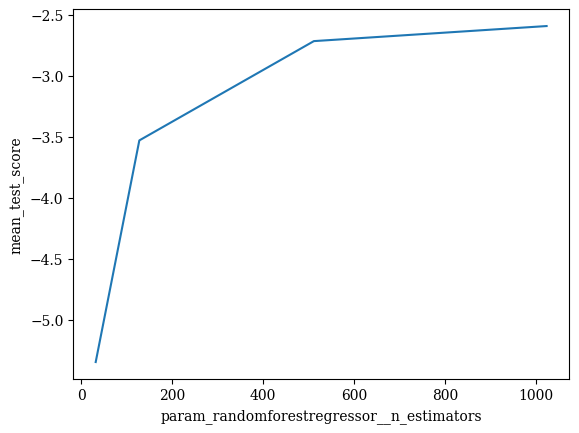

In [135]:
sns.lineplot(x="param_randomforestregressor__n_estimators", y="mean_test_score",
             #hue="param_randomforestregressor__max_features", # style="event",
             data=train_data)
plt.show()

%<br>
## Avaliação do modelo linear

In [136]:
print("Linear Regression Model")
print("Train Score: ", linReg.score(X_train, y_train))
print("Test Score: ", linReg.score(X_test, y_test))
print("Validation Score: ", r2_score(y_valid, linReg.predict(X_valid)))
print("RMSE Score: ", 100*rmse(y_train, linReg.predict(X_train)))

Linear Regression Model
Train Score:  0.01364033577955348
Test Score:  0.11849122729949368
Validation Score:  0.10885451787427292
RMSE Score:  57.65018102077312


[[ 1.76924745e-04  1.74562172e+00  2.27434302e-01 -4.08028881e-03]]


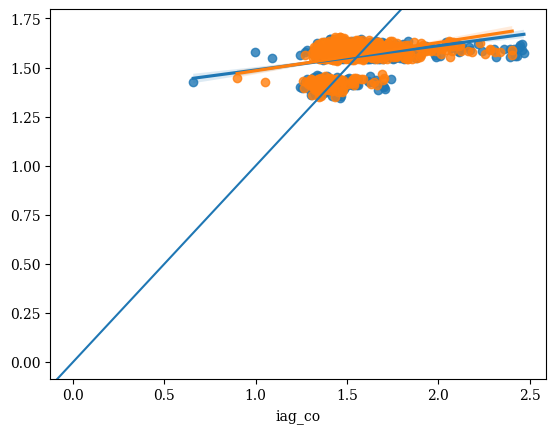

In [137]:
print(linReg.coef_)
# Visualização dos resultados do modelo linear
sns.regplot(x = y_valid, y = linReg.predict(X_valid))
sns.regplot(x = y_test, y = linReg.predict(X_test))
plt.gca().axline((0,0), slope=1)
plt.show()

%

r2_score(y_true, y_pred)<br>
x = X_train[:, 0]<br>
print("Sem regr", r2_score(x, y_train))<br>
print("w/o  ML model Score: ", r2_score(X_train['e2sp_co'], y_train))<br>
## Avaliação do modelo Random Forest

In [138]:
print("Random Forest Model")
print("Train Score: ", gs.score(X_train, y_train))
print("Test Score: ", gs.score(X_test, y_test))
print("Validation Score: ", r2_score(y_valid, gs.predict(X_valid)))
print("RMSE Score: ", 100*rmse(y_train.values, gs.predict(X_train)))
#print("RMSE Score: ", 100*rmse(y_train, gs.predict(X_train)))

Random Forest Model
Train Score:  0.8301306279267376
Test Score:  -2.4308491532057417
Validation Score:  -0.1590458285467753
RMSE Score:  69.72140183482435


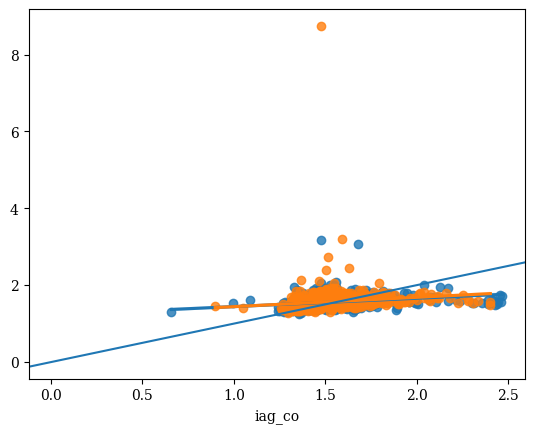

In [139]:
sns.regplot(x = y_valid, y = gs.predict(X_valid))
sns.regplot(x = y_test, y = gs.predict(X_test))
plt.gca().axline((0,0), slope=1)

In [ ]:
plt.show()

% Antes de tudo<br>
## Visualização do modelo calibrado vs referência

In [ ]:
e1_rf = {'co' : pd.DataFrame(data=gs.predict(Xco), index=Xco.index)}
# e1 = {'co' : df['e2sp_co']}
e2_ref = {'co' : df['iag_co']}

In [ ]:
plot_data_by_time_and_regr_plot(e1_rf, e2_ref, labels = ['co'], latex_labels = 'co')

%<br>
 ['2023-03-18 10:00:00':'2023-03-22 10:00:00'].

In [ ]:
e1_rf = {'co' : pd.DataFrame(data=linReg.predict(Xco), index=Xco.index)}
# e1 = {'co' : df['e2sp_co']}
e2_ref = {'co' : df['iag_co']}

In [ ]:
plot_data_by_time_and_regr_plot(e1_rf, e2_ref, labels = ['co'], latex_labels = 'co')